In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/enerjisa-enerji-veri-maratonu/generation.csv
/kaggle/input/enerjisa-enerji-veri-maratonu/sample_submission.csv
/kaggle/input/enerjisa-enerji-veri-maratonu/temperature.csv


In [2]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
pd.set_option('display.float_format', lambda x: '%.8f' % x)

In [3]:
# read csv files
gen = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/generation.csv', delimiter=';')
gen

,DateTime,Generation
0,01Jan2019 0:00:00,"0,0000000"
1,01Jan2019 1:00:00,"0,0000000"
2,01Jan2019 2:00:00,"0,0000080"
3,01Jan2019 3:00:00,"0,0000000"
4,01Jan2019 4:00:00,"0,0000080"
...,...,...
26299,NaN,NaN
26300,NaN,NaN
26301,NaN,NaN
26302,NaN,NaN


In [4]:
temp = pd.read_csv('../input/enerjisa-enerji-veri-maratonu/temperature.csv', delimiter=';')
temp

,DateTime,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
0,01Jan2019 0:00:00,"-1,70","-6,10","75,30","3,60",60.00000000,10.00000000,"6,30"
1,01Jan2019 1:00:00,"-1,80","-5,30","75,30","2,60",70.00000000,10.00000000,"4,50"
2,01Jan2019 2:00:00,"-2,00","-6,00","74,70","3,10",80.00000000,10.00000000,"5,50"
3,01Jan2019 3:00:00,"-1,90","-5,90","76,40","3,10",60.00000000,10.00000000,"7,60"
4,01Jan2019 4:00:00,"-2,00","-7,10","76,40","4,60",60.00000000,10.00000000,"6,50"
...,...,...,...,...,...,...,...,...
26394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:

df = pd.concat([gen.iloc[:25560], temp.iloc[:25560].drop('DateTime', axis=1)], axis=1)
df

,DateTime,Generation,AirTemperature,ComfortTemperature,RelativeHumidity,WindSpeed,WindDirection,WWCode,EffectiveCloudCover
0,01Jan2019 0:00:00,"0,0000000","-1,70","-6,10","75,30","3,60",60.00000000,10.00000000,"6,30"
1,01Jan2019 1:00:00,"0,0000000","-1,80","-5,30","75,30","2,60",70.00000000,10.00000000,"4,50"
2,01Jan2019 2:00:00,"0,0000080","-2,00","-6,00","74,70","3,10",80.00000000,10.00000000,"5,50"
3,01Jan2019 3:00:00,"0,0000000","-1,90","-5,90","76,40","3,10",60.00000000,10.00000000,"7,60"
4,01Jan2019 4:00:00,"0,0000080","-2,00","-7,10","76,40","4,60",60.00000000,10.00000000,"6,50"
...,...,...,...,...,...,...,...,...,...
25555,30Nov2021 19:00:00,"0,0000000","7,10","5,20","76,80","3,10",220.00000000,25.00000000,"6,00"
25556,30Nov2021 20:00:00,"0,0000000","7,10","5,70","75,20","2,10",250.00000000,80.00000000,"6,00"
25557,30Nov2021 21:00:00,"0,0000000","5,80","3,10","83,40","4,10",280.00000000,80.00000000,"7,00"
25558,30Nov2021 22:00:00,"0,0000000","5,00","3,30","81,00","2,10",240.00000000,60.00000000,"6,00"


In [6]:
object_cols = ['AirTemperature', 'ComfortTemperature', 'RelativeHumidity', 'WindSpeed', 'EffectiveCloudCover', 'Generation']
for col in object_cols:
    df[col] = df[col].apply(lambda x: float(x.replace(',', '.')))
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.set_index('DateTime')
df['WWCode'] = df['WWCode'].fillna(0).astype(int)

In [7]:
test = temp.iloc[25560:26304] # dates between 2021-12-1 and 2021-12-31
for col in object_cols[:5]:
    test[col] = test[col].apply(lambda x: float(x.replace(',', '.')))
test['DateTime'] = pd.to_datetime(test['DateTime'])
test = test.set_index('DateTime')
test['WWCode'] = test['WWCode'].fillna(0).astype(int) # Weather code filled with "0" again
test.loc[test['WWCode'] == 84, 'WWCode'] = 83 
# category 84 samples changed to 83 because category 84 is not found in train set and 83 is the nearest category to 84

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


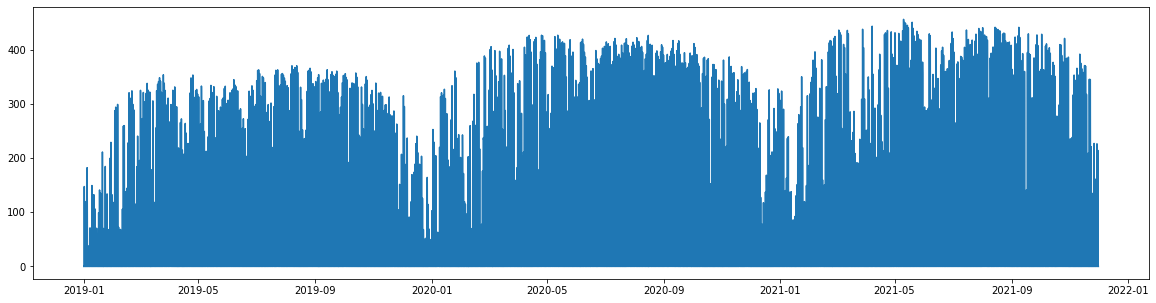

In [8]:
plt.figure(figsize=(20,5))
plt.plot(df['Generation'])
plt.show()


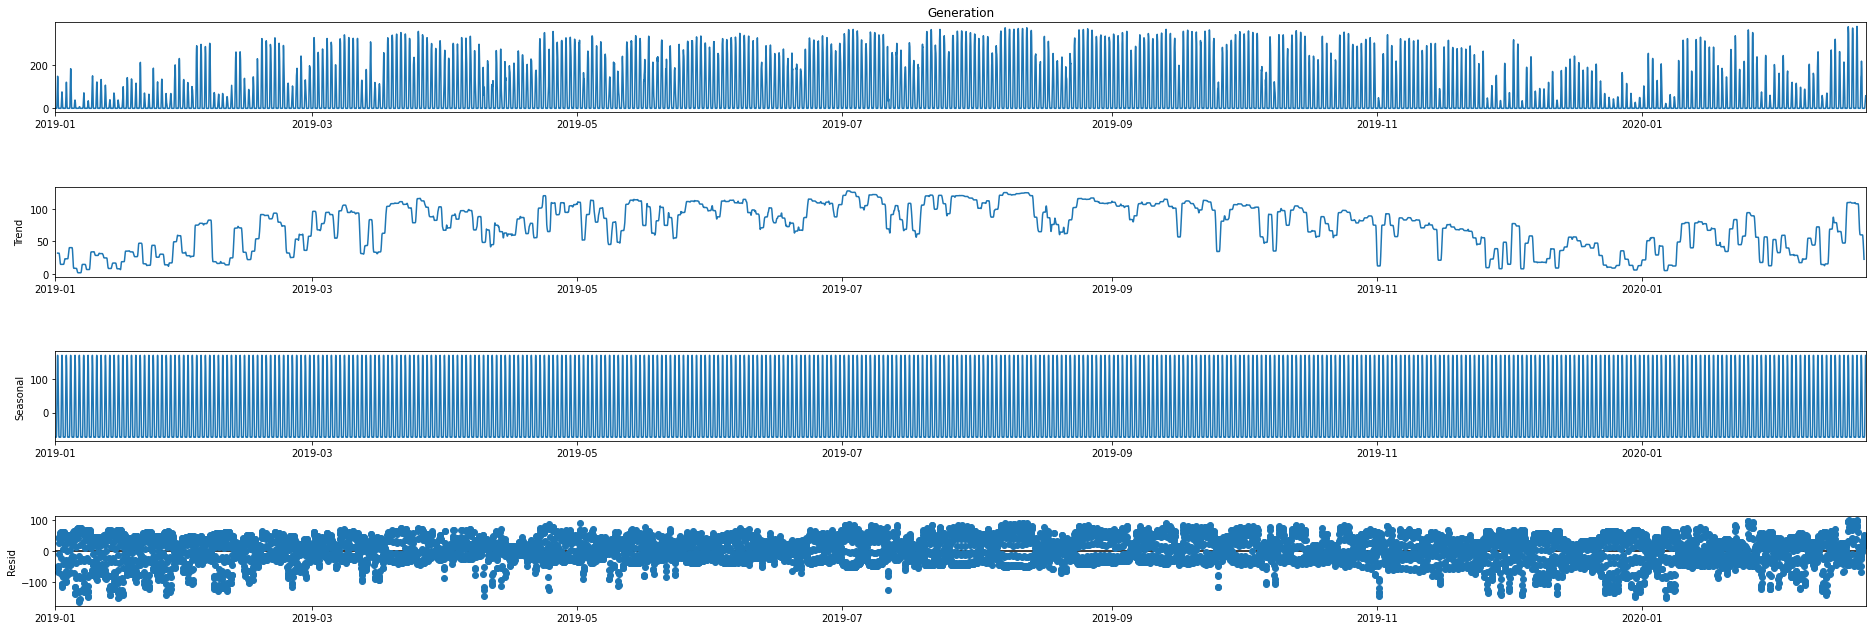

In [9]:
decomposition = sm.tsa.seasonal_decompose(df["Generation"][:10000], period=24)
fig = decomposition.plot()
fig.set_figwidth(30)
fig.set_figheight(10)

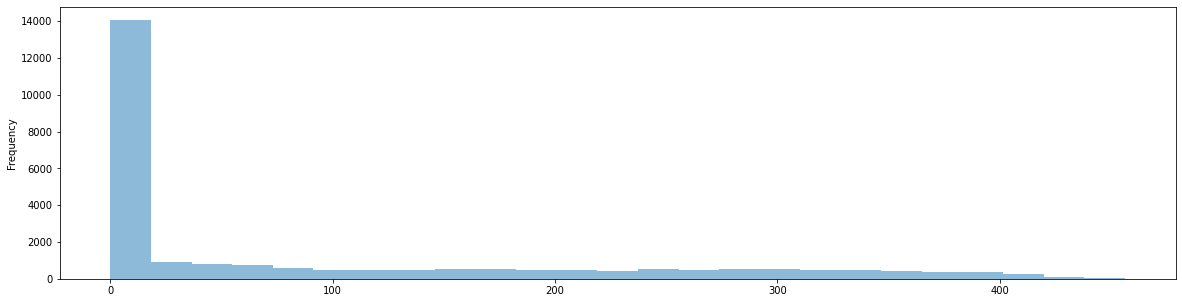

In [10]:
plt.figure(figsize=(20,5))
df['Generation'].plot.hist(bins=25, alpha=0.5)
plt.show()

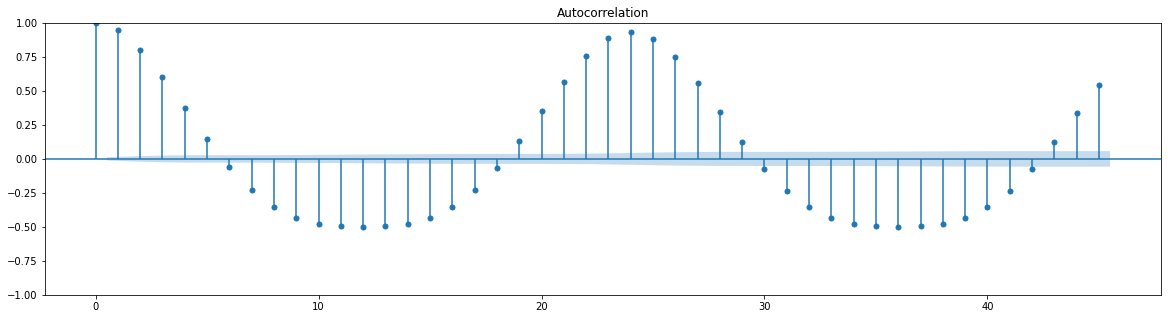

In [11]:
fig = plot_acf(df['Generation']);
fig.set_figwidth(20)
fig.set_figheight(5)

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


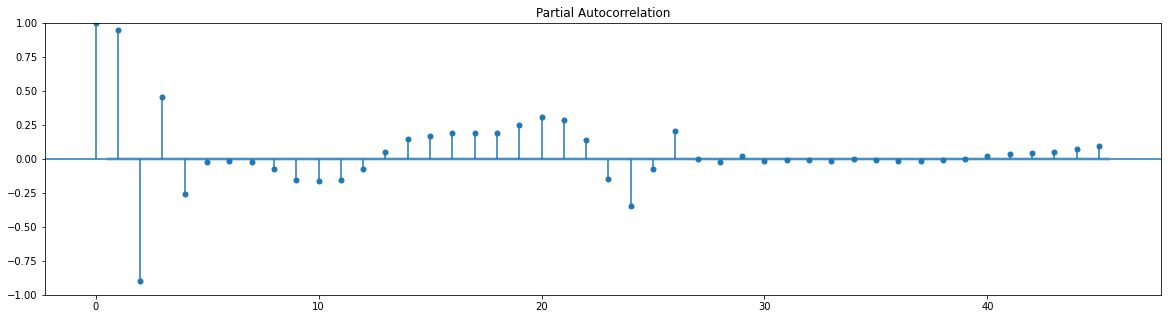

In [12]:
fig = plot_pacf(df['Generation']);
fig.set_figwidth(20)
fig.set_figheight(5)

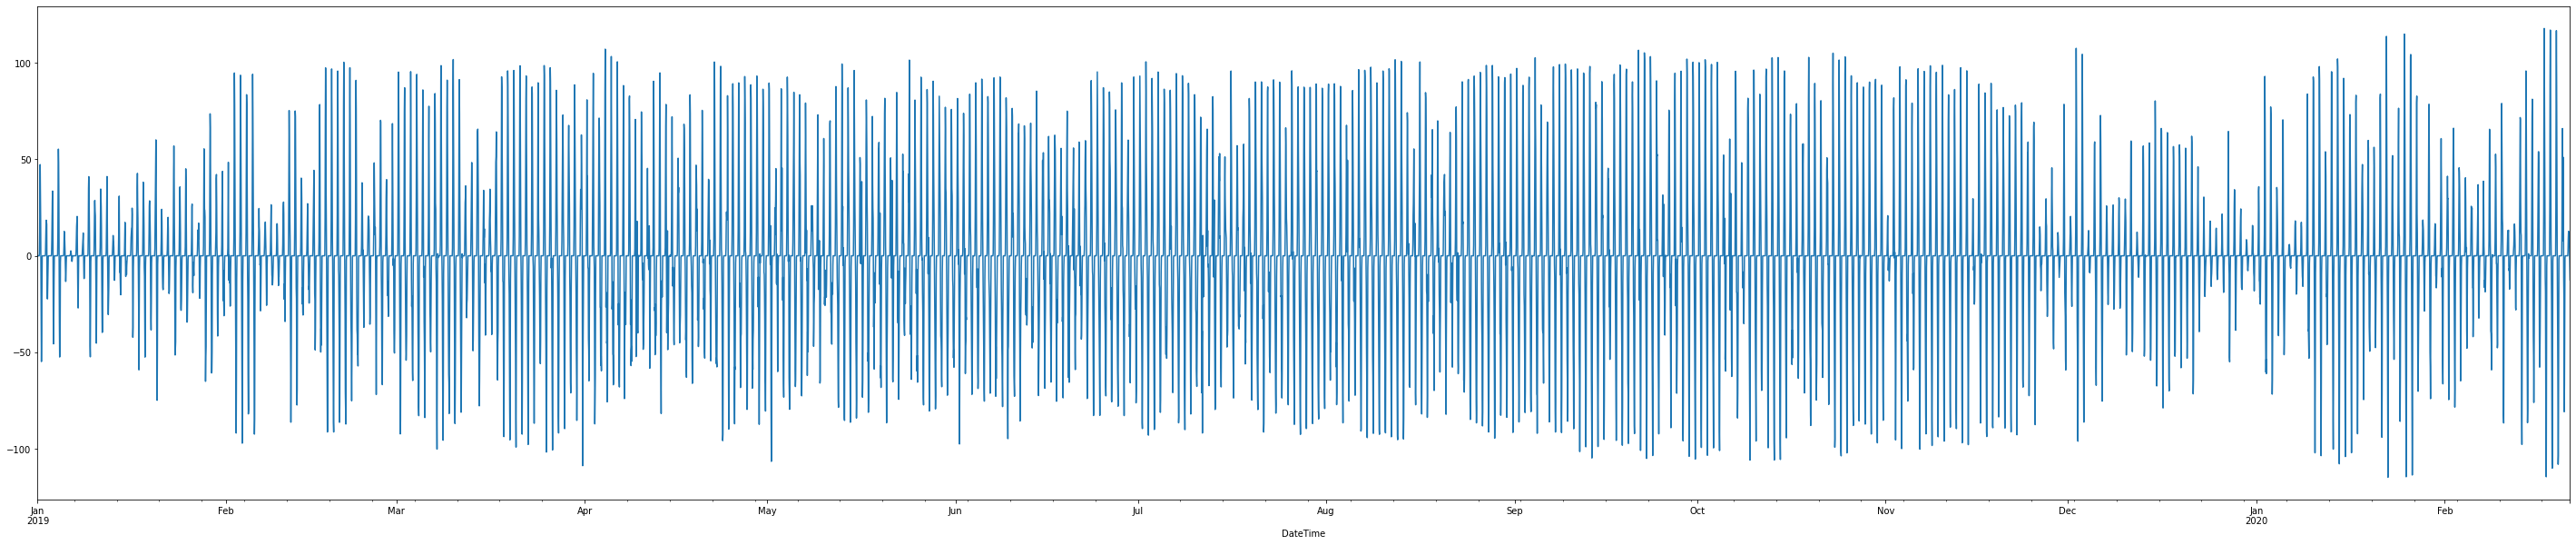

In [13]:
diff = df['Generation'].diff()
plt.figure(figsize=(50,10))
diff[:10000].plot()
plt.show()

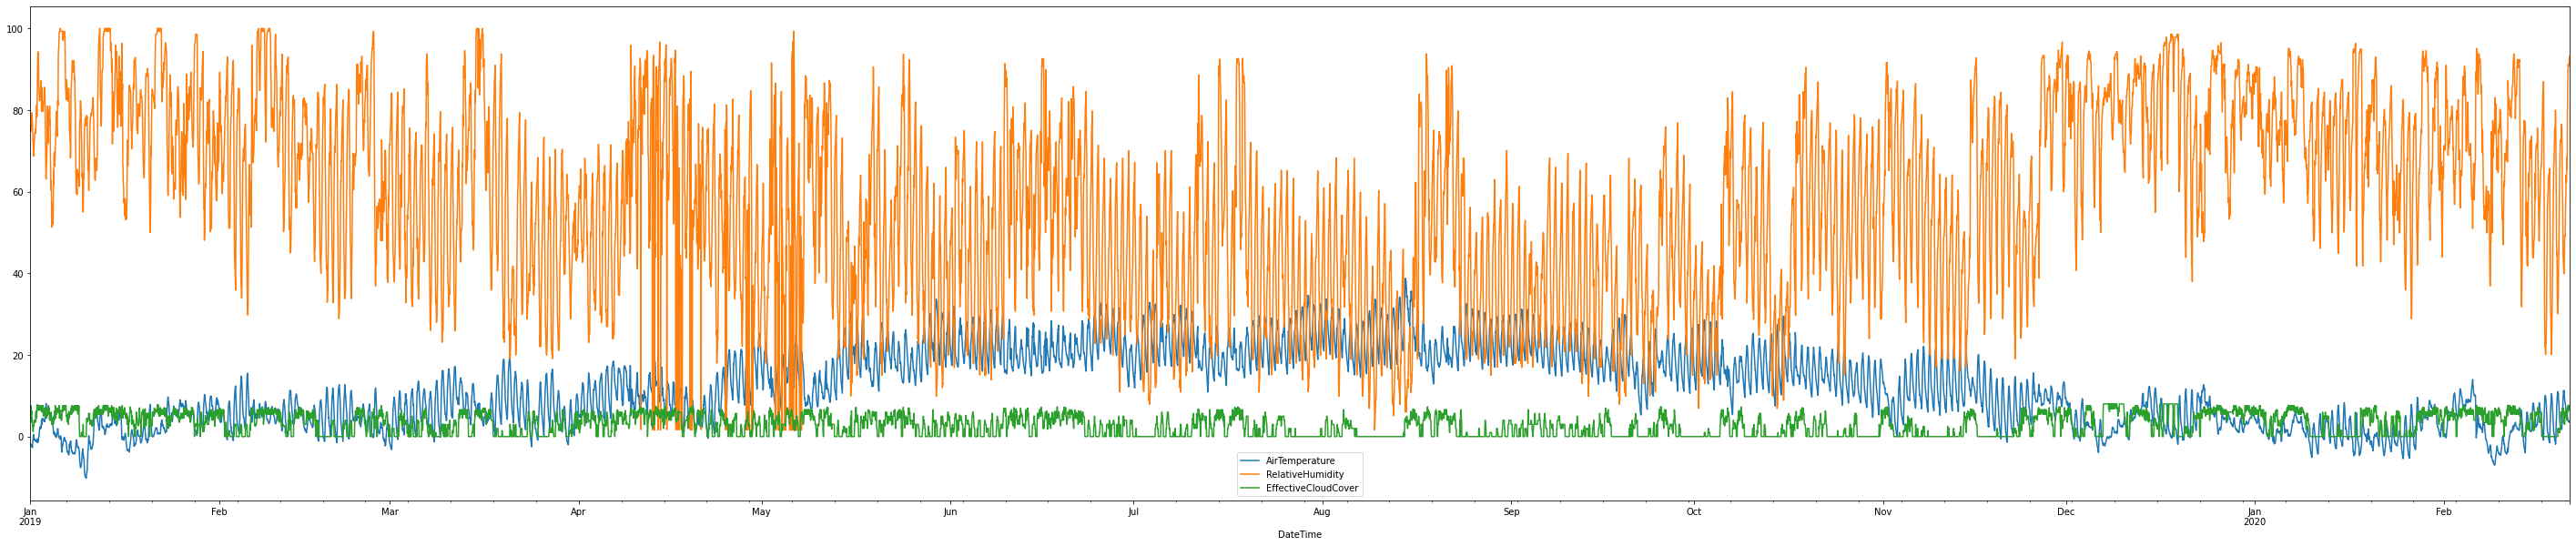

In [14]:
plt.figure(figsize=(50,10))
df['AirTemperature'][:10000].plot()
df['RelativeHumidity'][:10000].plot()
df['EffectiveCloudCover'][:10000].plot()
plt.legend(['AirTemperature', 'RelativeHumidity', 'EffectiveCloudCover'])
plt.show()


In [15]:
split_date = '2021-05-01'
train = df.loc[df.index <= split_date].copy()
val = df.loc[df.index > split_date].copy()

In [16]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df_copy = df.copy()
    df_copy['date'] = df_copy.index
    df_copy['hour'] = df_copy['date'].dt.hour
    df_copy['dayofweek'] = df_copy['date'].dt.dayofweek
    df_copy['quarter'] = df_copy['date'].dt.quarter
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['year'] = df_copy['date'].dt.year
    df_copy['dayofyear'] = df_copy['date'].dt.dayofyear
    df_copy['dayofmonth'] = df_copy['date'].dt.day
    df_copy['weekofyear'] = df_copy['date'].dt.weekofyear
    
    X = df_copy[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df_copy[label]
        return X, y
    return X

In [17]:
x_train, y_train = create_features(train, label='Generation')
x_val, y_val = create_features(val, label='Generation')
x_test = create_features(test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [18]:
x_train = pd.concat([x_train, train.drop('Generation', axis=1)], axis=1)
x_val = pd.concat([x_val, val.drop('Generation', axis=1)], axis=1)
x_test = pd.concat([x_test, test], axis=1)

In [19]:
model = XGBRegressor(
    random_state=42,
    tree_method="gpu_hist",
    gpu_id=0,
    predictor="gpu_predictor",
    n_estimators=5000
)
model.fit(x_train, y_train)

[16:19:41] WARNING: ../src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1


XGBoostError: [16:19:41] ../src/gbm/gbtree.cc:531: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.
Stack trace:
  [bt] (0) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x179639) [0x7fc8bbb6c639]
  [bt] (1) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x179c6a) [0x7fc8bbb6cc6a]
  [bt] (2) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x17a3ba) [0x7fc8bbb6d3ba]
  [bt] (3) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(+0x1b48c5) [0x7fc8bbba78c5]
  [bt] (4) /opt/conda/lib/python3.7/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x68) [0x7fc8bba8c4f8]
  [bt] (5) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7fc9437eba4a]
  [bt] (6) /opt/conda/lib/python3.7/lib-dynload/../../libffi.so.8(+0x5fea) [0x7fc9437eafea]
  [bt] (7) /opt/conda/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(_ctypes_callproc+0x2f4) [0x7fc943801784]
  [bt] (8) /opt/conda/lib/python3.7/lib-dynload/_ctypes.cpython-37m-x86_64-linux-gnu.so(+0x10ff8) [0x7fc943801ff8]

